# Analyse the literature

## Imports and function definitions

In [94]:
import pandas as pd
import matplotlib as mpl
from mpl_toolkits.axes_grid1 import make_axes_locatable
# No touchie. Make the font the same as the LaTeX paper
mpl.rc('font', family='serif', serif='cmr10', size=18)
mpl.rc('axes.formatter', use_mathtext=True)
import matplotlib.pyplot as plt
import seaborn as sns
import re
pd.set_option('display.max_rows', 100)
pd.set_option('display.max_columns', 30)
import numpy as np

A4_WIDTH_INCHES = 8.25
WIDTH = 5.5

FINAL = True

def watermark(ax):
    if FINAL:
        return
    ax.text(
        0.5, 
        0.5, 
        'Visualisation not final', 
        transform=ax.transAxes,
        fontsize=40, 
        color='gray', 
        alpha=0.5,
        ha='center', 
        va='center', 
        rotation=30
    )

    
replacements = {
    "5Dt": "5DT",
    "App": "Application",
    "Ar": "Augmented Reality",
    "Based On": "Based-on",
    "Cnn": "CNN",
    "Cyberglove": "CyberGlove",
    "Cyberglove Ii": "CyberGlove II",
    "Dataglove": "DataGlove",
    "Deep Q Network": "Deep Q-Network",
    "Emg": "EMG",
    "Ffnn": "FFNN",
    "Gmm": "GMM",
    "Gru": "GRU",
    "Hmm": "HMM",
    "Imu": "IMU",
    "K Means": "k-Means",
    "Knn": "KNN",
    "Lstm": "LSTM",
    "Msc": "Master's Thesis",
    "Myomonitor Iv": "Myomonitor IV",
    "Nn": "NN",
    "Pca": "PCA",
    "Powerglove": "PowerGlove",
    "Rgb": "RGB",
    "Rgbd": "RGBD",
    "Rnn": "RNN",
    "Sl": "Sign Language",
    "Som": "SOM",
    "Svd": "Svd",
    "Svm": "SVM",
    "Tdnn": "TDNN",
    "Tech": "Technology",
    "Tub": "TUB",
    "Uwave": "uWave",
    "Vpl": "VPL",
    "Vr": "Virtual Reality",
    "Wifi": "WiFi",
#     "Naive Bayes": "Naïve-Bayes", # Matplotlib doesn't understand 'ï'
} 
def prettify_text(text):
    text = text.replace('-', ' ').title()
    for k, v in replacements.items():
        text = re.sub(r'\b' + k + r'\b', v, text, 0)
    return text
    
def prettify_ax(ax):
    ax.grid()
    ax.set_xlabel(prettify_text(ax.get_xlabel()))
    ax.set_ylabel(prettify_text(ax.get_ylabel()))

#     ax.set_xticks(ax.get_xticks())
#     ax.set_xticklabels([
#         prettify_text(label.get_text())
#         for label
#         in ax.get_xticklabels()
#     ])
    ax.set_yticks(ax.get_yticks())
    ax.set_yticklabels([
        prettify_text(label.get_text())
        for label
        in ax.get_yticklabels()
    ])

    legend = ax.get_legend()
    if legend:
        for txt in legend.get_texts():
            txt.set_text(prettify_text(txt.get_text()))

        legend.set_title(prettify_text(legend.get_title().get_text()))

    return ax

def prettify_xticks(ax):
    ax.set_xticks(ax.get_xticks())
    ax.set_xticklabels([
        prettify_text(label.get_text())
        for label
        in ax.get_xticklabels()
    ])
def prettify_yticks(ax):
    ax.set_yticks(ax.get_yticks())
    ax.set_yticklabels([
        prettify_text(label.get_text())
        for label
        in ax.get_yticklabels()
    ])

def dedup_prefix(df, prefix):
    """Taken in a dataframe and a prefix column that contains values like `abc+123+efg.
    Split those values up so they take multiple rows, containing `abc`, `123`, `efg`."""
    assert prefix in df.columns, f'prefix `{prefix}` is not in df.columns:\n{df.columns.to_list()}'
    list_of_series = []
    for i, row in df.iterrows():
        if pd.notna(row[prefix]) and '+' in row[prefix]:
            for item in row[prefix].split('+'):
                tmp_row = row.copy()
                tmp_row[prefix] = item
                list_of_series.append(tmp_row)
        else:
            list_of_series.append(row)
    return pd.DataFrame(list_of_series).reset_index(drop=True)

def fmt_legend(ax=None, handles_labels=None, **kwargs):
    if ax is None:
        ax = plt.gca()
    if handles_labels is None:
        handles, labels = ax.get_legend_handles_labels()
    else:
        handles, labels = handles_labels
    ax.legend(
        handles=handles,
        labels=labels,
        borderpad=0.5,
        labelspacing=0.1,
        handlelength=0.1,
        **kwargs,
    )
    return ax

def add_grid(ax=None, **kwargs):
    if ax is None:
        ax = plt.gca()
    ax.grid(
        'both',
        **(
            dict(
                alpha=0.25,
                lw=1,
            ) | kwargs
        )
    )
    ax.set_axisbelow(True)
    return ax

def add_cbar(
    fig, ax, data,
    label=None,
    cmap='Spectral',
    vmin=None,
    vmax=None,
) -> None:
    divider = make_axes_locatable(ax)
    cax = divider.append_axes('right', size='2.5%', pad=0.05)

    norm = mpl.colors.Normalize(
        vmin=vmin if vmin is not None else data.min(),
        vmax=vmax if vmax is not None else data.max(),
    )

    cb = fig.colorbar(
        mpl.cm.ScalarMappable(norm=norm, cmap=cmap),
        cax=cax,
        orientation='vertical',
        label=label
    )
    cb.outline.set_visible(False)

## Read in the data

In [57]:
# Read in the data
date_cols = ['Date', 'Publication Year', 'Date Added', 'Date Modified', 'Access Date']
df = pd.read_csv(
    './src/zotero.csv', 
    parse_dates=date_cols
)
df['Date'] = pd.to_datetime(df['Date'], format='ISO8601')

def get_citations(x):
    if x is None or pd.isna(x):
        return None
    RE = r'(\d+) citations'
    match = re.search(RE, x, flags=re.IGNORECASE)
    return None if match is None else int(match.groups()[0])

# Extract citations
df['citations'] = df['Extra'].apply(get_citations)

# Extract nicely formatted tags as a list of key:value objects
df['tags'] = df['Manual Tags'].str.split('; ').apply(lambda x: x if type(x) is list or pd.notna(x) else [])

# # https://stackoverflow.com/a/952952/14555505
uniq_tags = sorted(list(set([item for sublist in df['tags'] for item in sublist])))

# Make a helper function to check if tag(s) is/are in a series
def has_tag(tag, series):
    if type(tag) is list:
        return series.apply(lambda x: any(t in x for t in tag))
    else:
        return series.apply(lambda x: tag in x)

# Make a helper function to extract the references from the Extras field
def extract_references(extra):
    if pd.isna(extra):
        return []
    regex = r'--- DOIs_of_references: (\[.*\]) ---'
    match = re.search(regex, extra)
    if match is None:
        return []
    dois_str = match.groups()[0]
    return sorted([l[1:-1] for l in dois_str[1:-1].split(',')])

df['references'] = df['Extra'].apply(extract_references)

# Get a shortcut column for the year
df['year'] = df['Date'].dt.year

In [58]:
# Organise the data

# Add columns to the dataset, one for each prefix
prefixes = sorted(set([t.split(':')[0] for t in uniq_tags if ':' in t]))

# Make a column for all `prefix`:`value` type tags
def make_prefix_value(tags, prefix, sep=':'):
    s = '+'.join(sorted([tag.replace(prefix + sep, '') for tag in tags if (prefix+sep) in tag]))
    return s if s else np.NaN

for prefix in prefixes:
    df[prefix] = df['tags'].apply(lambda tags: make_prefix_value(tags, prefix))

# Attempt to infer better dtypes for object columns.
df = df.infer_objects()

# Fidelity

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/seaborn/categorical.py:3370: UserWarning: 8.0% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/seaborn/categorical.py:3370: UserWarning: 8.0% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/seaborn/categorical.py:3370: UserWarning: 8.0% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)


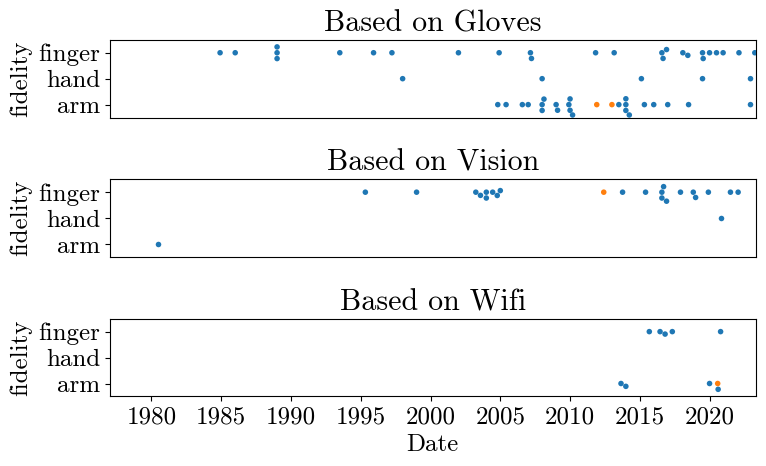

In [4]:
fig, axs = plt.subplots(3, 1, figsize=(8, 5))
data = dedup_prefix(dedup_prefix(df, 'fidelity'), 'based-on')

data = data[
    data['type'].notna() & 
    data['type'].isin(['paper', 'msc', 'dataset'])
]
based_ons = ('gloves', 'vision', 'wifi')
for i, based_on in enumerate(based_ons):
    sns.swarmplot(
        data=data[data['based-on'] == based_on],
        x="Date", 
        y="fidelity",
        hue='type',
#         hue_order=based_ons,
        order=['finger', 'hand', 'arm'],
        size=4,
        ax=axs[i],
        legend=False,
    )
    axs[i].set(
        title=f'Based on {based_on.title()}',
        xlim=(data['Date'].min(), data['Date'].max())
    )
    if i != len(based_ons)-1:
        axs[i].set(
            xticks=[],
            xlabel=None,
        )
#         vis.add_grid(axs[i])
plt.tight_layout()
# plt.title('Types of Research over Time');
# watermark(ax)
# ax = prettify_ax(ax)


# Static vs Dynamic Movement

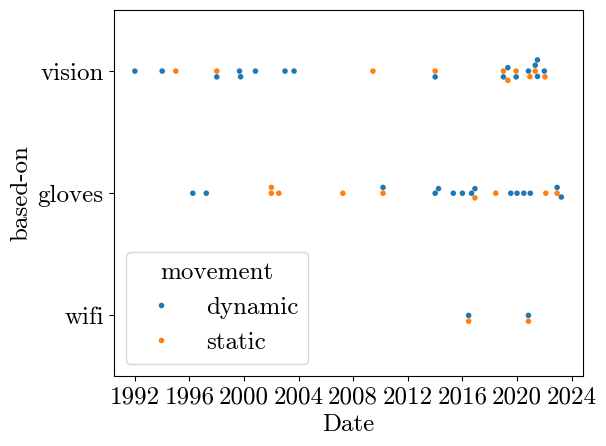

In [5]:
# fig, axs = plt.subplots(2, 1, figsize=(8, 5))
data = dedup_prefix(dedup_prefix(df, 'movement'), 'based-on')

sns.swarmplot(
    data=data,
    x="Date", 
    hue="movement",
    y='based-on',
    size=4,
#     legend=False,
)
plt.tight_layout()

# Paper types over time

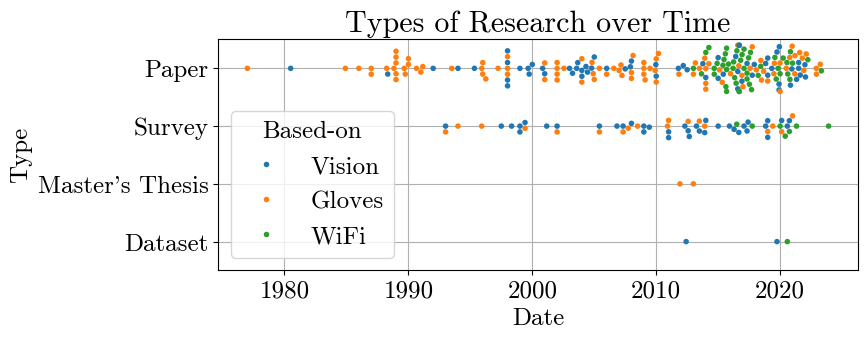

In [6]:
fig, ax = plt.subplots(figsize=(A4_WIDTH_INCHES,3))
data = dedup_prefix(dedup_prefix(df, 'type'), 'based-on')

data = data[
    data['type'].notna() & 
    data['type'].isin(['paper', 'survey', 'msc', 'dataset'])
]

sns.swarmplot(
    data=data, 
    x="Date", 
    y="type",
    hue='based-on',
    size=4,
    ax=ax
)
plt.title('Types of Research over Time');
watermark(ax)
ax = prettify_ax(ax)


# Surveys vs citations over time

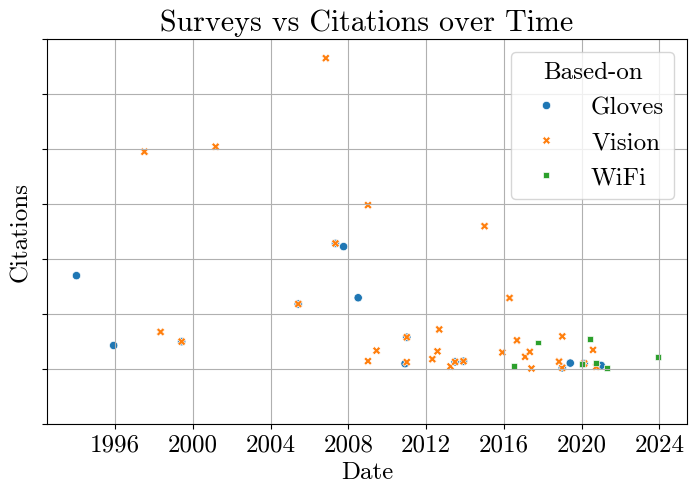

,Author,Date,citations,Title,based-on,type
105,"Sturman, D.J.; Zeltzer, D.",1994-01-01,853.0,A survey of glove-based input,gloves,survey
107,"Pavlovic, Vladimir I.; Sharma, R.; Huang, T.S.",1997-07-01,1979.0,Visual interpretation of hand gestures for hum...,vision,survey
268,"Moeslund, Thomas B.; Granum, Erik",2001-03-01,2025.0,A Survey of Computer Vision-Based Human Motion...,vision,survey
155,"Ong, S.C.W.; Ranganath, S.",2005-06-01,595.0,Automatic Sign Language Analysis: A Survey and...,gloves,survey
156,"Ong, S.C.W.; Ranganath, S.",2005-06-01,595.0,Automatic Sign Language Analysis: A Survey and...,vision,survey
214,"Moeslund, Thomas B.; Hilton, Adrian; Krüger, V...",2006-11-01,2830.0,A survey of advances in vision-based human mot...,vision,survey
54,"Mitra, Sushmita; Acharya, Tinku",2007-05-01,1146.0,Gesture Recognition: A Survey,gloves,survey
55,"Mitra, Sushmita; Acharya, Tinku",2007-05-01,1146.0,Gesture Recognition: A Survey,vision,survey
380,"Asghari Oskoei, Mohammadreza; Hu, Huosheng",2007-10-01,1117.0,Myoelectric control systems—A survey,gloves,survey
119,"Dipietro, L.; Sabatini, A.M.; Dario, P.",2008-07-01,652.0,A Survey of Glove-Based Systems and Their Appl...,gloves,survey


In [7]:
fig, ax = plt.subplots(figsize=(A4_WIDTH_INCHES, 5))
deduped = dedup_prefix(dedup_prefix(df, 'type'), 'based-on')

deduped = deduped[deduped.type == 'survey']
sns.scatterplot(
    data=deduped, 
    x="Date", 
    y="citations",
    style='based-on',
    hue='based-on',
    ax=ax,
)
plt.title('Surveys vs Citations over Time')
watermark(ax)
ax = prettify_ax(ax)

plt.show()

deduped.loc[
    deduped.citations > 500, 
    ['Author', 'Date', 'citations', 'Title', 'based-on', 'type']
].sort_values('Date')

# Surveys vs citations over time

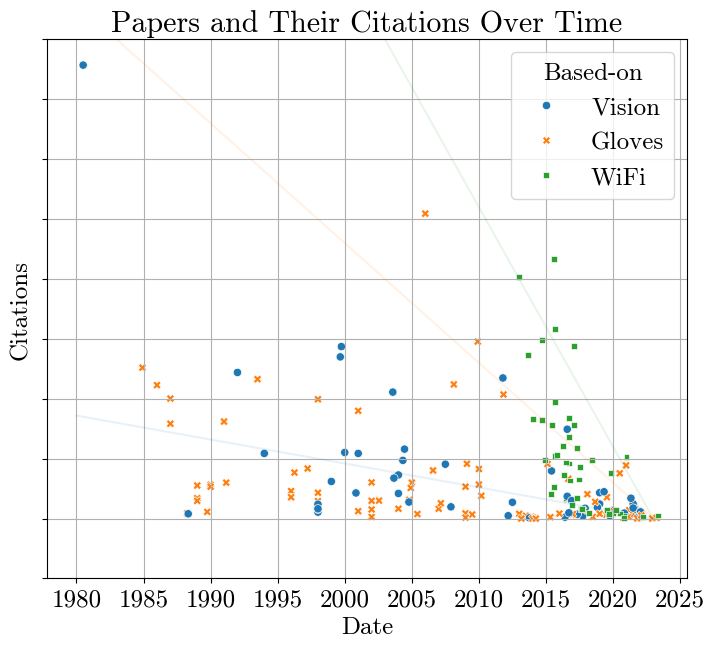

,Author,Title,Date,citations,type,based-on
4,"Zimmerman, Thomas G.; Lanier, Jaron; Blanchard...",A hand gesture interface device,1987-01-01,501.0,paper,gloves
5,"Xu Zhang; Xiang Chen; Yun Li; Lantz, V.; Kongq...",A Framework for Hand Gesture Recognition Based...,2011-11-01,518.0,paper,gloves
99,"Chen, Feng-Sheng; Fu, Chih-Ming; Huang, Chung-Lin",Hand gesture recognition using a real-time tra...,2003-08-01,528.0,paper,vision
326,"Jacobsen, S.; Iversen, E.; Knutti, D.; Johnson...",Design of the Utah/M.I.T. Dextrous Hand,1986-01-01,557.0,paper,gloves
37,"Schlömer, Thomas; Poppinga, Benjamin; Henze, N...",Gesture recognition with a Wii controller,2008-02-18,560.0,paper,gloves
100,"Baudel, Thomas; Beaudouin-Lafon, Michel",Charade: remote control of objects using free-...,1993-07-01,582.0,paper,gloves
112,"Harrison, Chris; Benko, Hrvoje; Wilson, Andrew D.",OmniTouch: wearable multitouch interaction eve...,2011-10-16,587.0,paper,vision
163,"Yamato, J.; Ohya, J.; Ishii, K.",Recognizing human action in time-sequential im...,1992-01-01,610.0,paper,vision
325,"Jacobsen, S.C.; J.E. Wood; D.F. Knutti; Bigger...",The UTAH/M.I.T. Dextrous Hand: Work in Progress,1984-12-01,630.0,paper,gloves
71,"Wilson, A.D.; Bobick, A.F.",Parametric hidden Markov models for gesture re...,1999-09-01,675.0,paper,vision


In [8]:
fig, ax = plt.subplots(figsize=(A4_WIDTH_INCHES, 7))
deduped = dedup_prefix(dedup_prefix(df, 'type'), 'based-on')

deduped = deduped[deduped.type == 'paper']
sns.scatterplot(
    data=deduped, 
    x="Date", 
    y="citations",
    style='based-on',
    hue='based-on',
    ax=ax,
)
plt.title('Papers and Their Citations Over Time')
ylim = ax.get_ylim()
c_per_y = [10, 50, 100]
for c in c_per_y:
    ax.plot(
        [pd.to_datetime('2023-01-01'), pd.to_datetime('1980-01-01')], 
        [0, c * (2023-1980)], 
        alpha=0.1
    )
ax.set_ylim(ylim)
watermark(ax)
ax = prettify_ax(ax)

plt.show()

(df.loc[
    (df.citations > 500) & (df.type == 'paper'),
    ['Author', 'Title', 'Date', 'citations', 'type', 'based-on']
]
.sort_values('citations'))

# Hardware used for glove-based systems

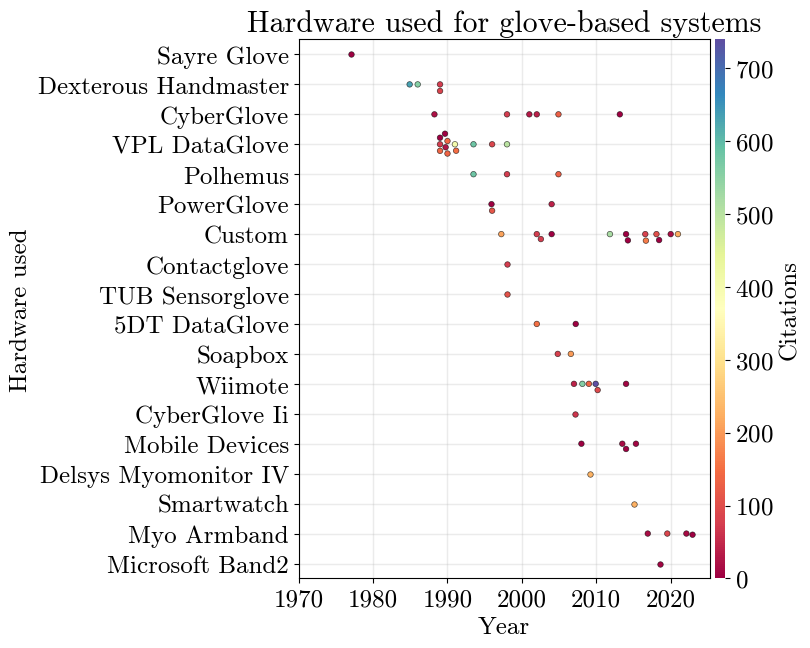

In [106]:
fig, ax = plt.subplots(figsize=(WIDTH, 7))

deduped = dedup_prefix(dedup_prefix(df, 'hardware'), 'based-on')
deduped = deduped[
    (deduped.type == 'paper') &
    (deduped['based-on'] == 'gloves') & 
    deduped['hardware'].notna()
]
deduped['citations'] = deduped['citations'].fillna(0)
sns.swarmplot(
    data=deduped.sort_values('Date'), 
    x="Date", 
    y="hardware",
    hue_norm=(0, deduped['citations'].max()),
    hue='citations',
    legend=False,
    linewidth=0.5,
    edgecolor='#000a',
    palette='Spectral',
    size=4, 
    ax=ax
)
# watermark(ax)
# ax = prettify_ax(ax)

add_grid(ax)
add_cbar(
    fig, ax, deduped['citations'], label='Citations'
)
# fmt_legend(ax, title='Citations')
ax.set(
    xlabel='Year',
    ylabel='Hardware used',
    title='Hardware used for glove-based systems',
    xticks=ax.get_xticks()[::2],
    xticklabels=ax.get_xticklabels()[::2],
)
prettify_yticks(ax)

plt.savefig('./src/imgs/graphs/03_hardware_for_gloves.pdf', bbox_inches='tight')

# Tech used for glove-based systems

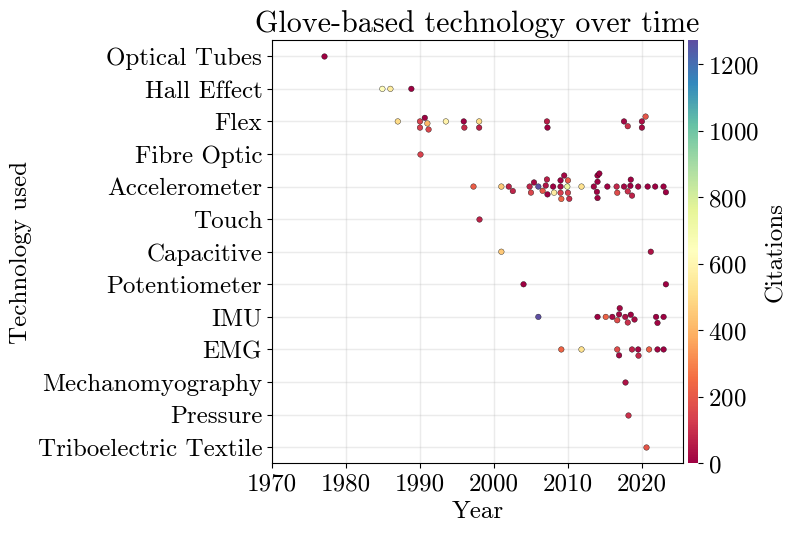

In [66]:
fig, ax = plt.subplots(figsize=(WIDTH, WIDTH))

deduped = dedup_prefix(dedup_prefix(df, 'tech'), 'based-on')

deduped = deduped[
    (deduped.type == 'paper') &
    (deduped['based-on'] == 'gloves') &
    (~deduped['tech'].isin(['rgb'])) &
    (deduped['tech'].notna())
].sort_values('Date')
deduped['citations'] = deduped['citations'].fillna(0)

sns.swarmplot(
    data=deduped, 
    x="Date", 
    y="tech",
    hue='citations',
    hue_norm=(0, deduped['citations'].max()),
    palette='Spectral',
    edgecolor='#000',
    linewidth=0.25,
    legend=False,
    size=4, 
    ax=ax
)
add_grid(ax)
add_cbar(
    fig, ax, deduped['citations'], label='Citations'
)
# fmt_legend(ax, title='Citations')
ax.set(
    xlabel='Year',
    ylabel='Technology used',
    title='Glove-based technology over time',
    xticks=ax.get_xticks()[::2],
    xticklabels=ax.get_xticklabels()[::2],
)
prettify_yticks(ax)

plt.savefig('./src/imgs/graphs/03_tech_for_gloves.pdf', bbox_inches='tight')

In [72]:
deduped.sort_values('citations', ascending=False)[['Date', 'Author', 'Title', 'citations']]

,Date,Author,Title,citations
245,2006-01-01,"Karantonis, D.M.; Narayanan, M.R.; Mathie, M.;...",Implementation of a Real-Time Human Movement C...,1273.0
244,2006-01-01,"Karantonis, D.M.; Narayanan, M.R.; Mathie, M.;...",Implementation of a Real-Time Human Movement C...,1273.0
191,2009-12-01,"Liu, Jiayang; Zhong, Lin; Wickramasuriya, Jeha...",uWave: Accelerometer-based personalized gestur...,739.0
374,1984-12-01,"Jacobsen, S.C.; J.E. Wood; D.F. Knutti; Bigger...",The UTAH/M.I.T. Dextrous Hand: Work in Progress,630.0
123,1993-07-01,"Baudel, Thomas; Beaudouin-Lafon, Michel",Charade: remote control of objects using free-...,582.0
48,2008-02-18,"Schlömer, Thomas; Poppinga, Benjamin; Henze, N...",Gesture recognition with a Wii controller,560.0
375,1986-01-01,"Jacobsen, S.; Iversen, E.; Knutti, D.; Johnson...",Design of the Utah/M.I.T. Dextrous Hand,557.0
6,2011-11-01,"Xu Zhang; Xiang Chen; Yun Li; Lantz, V.; Kongq...",A Framework for Hand Gesture Recognition Based...,518.0
7,2011-11-01,"Xu Zhang; Xiang Chen; Yun Li; Lantz, V.; Kongq...",A Framework for Hand Gesture Recognition Based...,518.0
5,1987-01-01,"Zimmerman, Thomas G.; Lanier, Jaron; Blanchard...",A hand gesture interface device,501.0


Text(0.5, 1.0, 'Applications of Gesture Recognition')

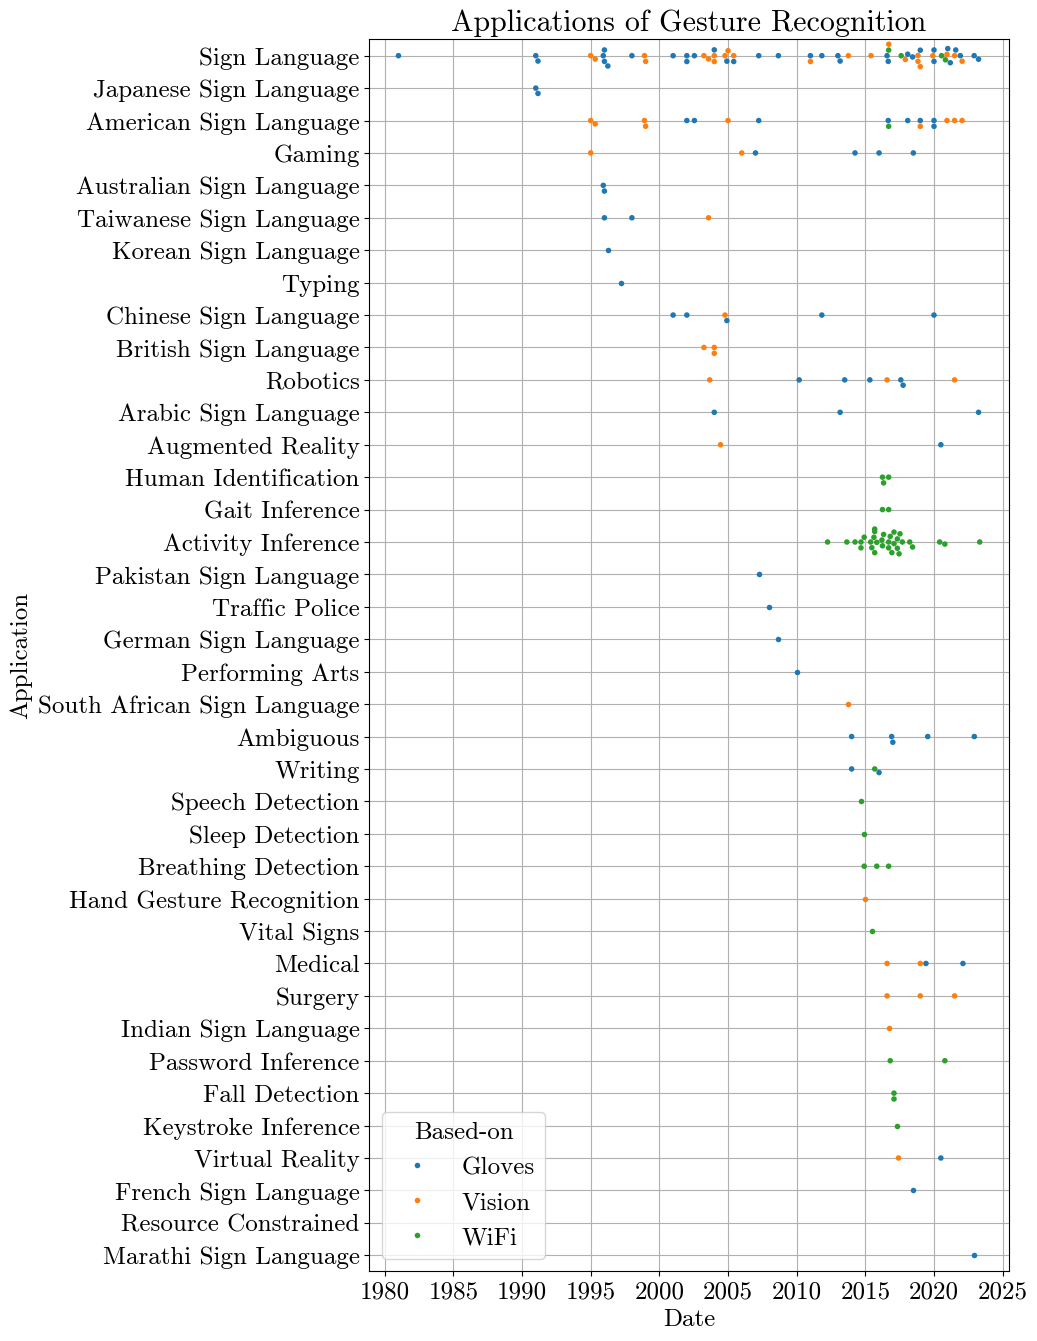

In [60]:
fig, ax = plt.subplots(figsize=(A4_WIDTH_INCHES,16))

data = dedup_prefix(dedup_prefix(df, 'app'), 'based-on').sort_values('Date')
data = data[
    data['app'].notna()
]

sns.swarmplot(
    data=data, 
    x="Date", 
    y="app",
    hue='based-on',
    size=4, 
    ax=ax
)
watermark(ax)
ax = prettify_ax(ax)

plt.title('Applications of Gesture Recognition')
# plt.savefig('./src/imgs/graphs/03_applications.pdf', bbox_inches='tight')

# Applications of vision/wifi gesture detection

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/seaborn/categorical.py:3370: UserWarning: 6.2% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/seaborn/categorical.py:3370: UserWarning: 6.2% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/seaborn/categorical.py:3370: UserWarning: 6.2% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)


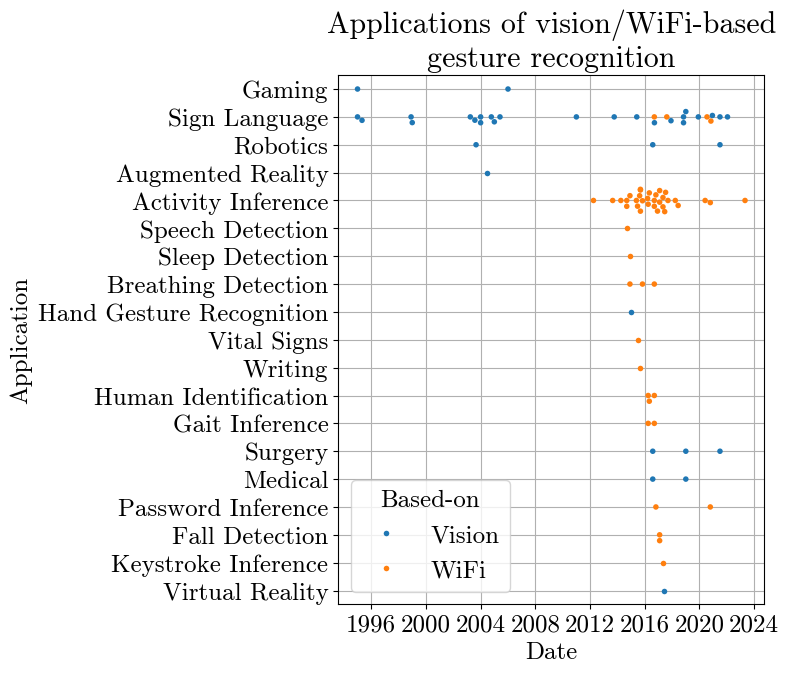

In [150]:
fig, ax = plt.subplots(figsize=(WIDTH,WIDTH*1.25))

data = dedup_prefix(dedup_prefix(df, 'app'), 'based-on').sort_values('app')
data = data[
    (data['based-on'].isin(['wifi', 'vision'])) & 
    (data['app'].notna()) & 
    (data['app'].apply(lambda x: '-sl' not in str(x)))
].sort_values('Date')
# order = data.groupby('app').size().sort_values(ascending=False).index

sns.swarmplot(
    data=data, 
    x="Date", 
    y="app",
    hue='based-on',
#     order=order,
    size=4, 
    ax=ax
)
watermark(ax)
ax = prettify_ax(ax)

plt.title('Applications of vision/WiFi-based\ngesture recognition')
plt.savefig('./src/imgs/graphs/03_wifi_vision_applications.pdf', bbox_inches='tight')

# Sign-language applications

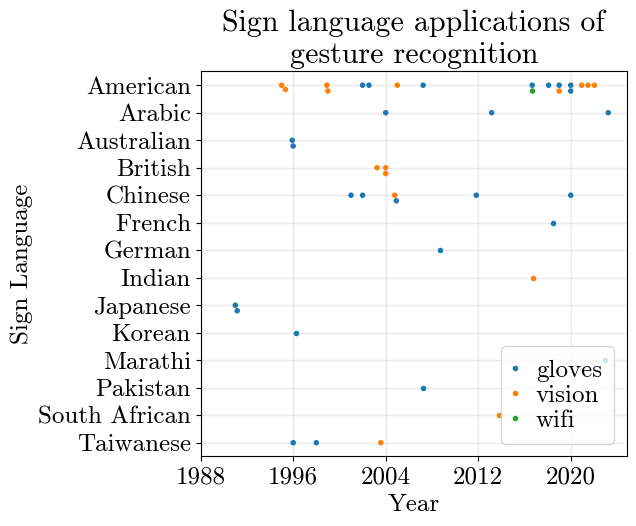

In [169]:
fig, ax = plt.subplots(figsize=(WIDTH, 5))
data = dedup_prefix(dedup_prefix(df, 'app'), 'based-on').sort_values('app')
data = data[data.app.apply(lambda x: '-sl' in str(x))]
sns.swarmplot(
    data=data, 
    x="Date", 
    y="app",
    hue='based-on',
    size=4, 
    ax=ax
)

add_grid(ax)
ax.set(
    xlabel='Year',
    ylabel='Sign Language',
    title='Sign language applications of\ngesture recognition',
    xticks=ax.get_xticks()[::2],
    xticklabels=ax.get_xticklabels()[::2],
    yticks=ax.get_yticks(),
    yticklabels=[
        t.get_text().replace('-', ' ').replace(' sl', '').title()
        for t 
        in ax.get_yticklabels()
    ]
)
fmt_legend(ax)

plt.savefig('./src/imgs/graphs/03_sl_applications.pdf', bbox_inches='tight')

Text(0.5, 1.0, 'Models Used for Glove-based Gesture Recognition')

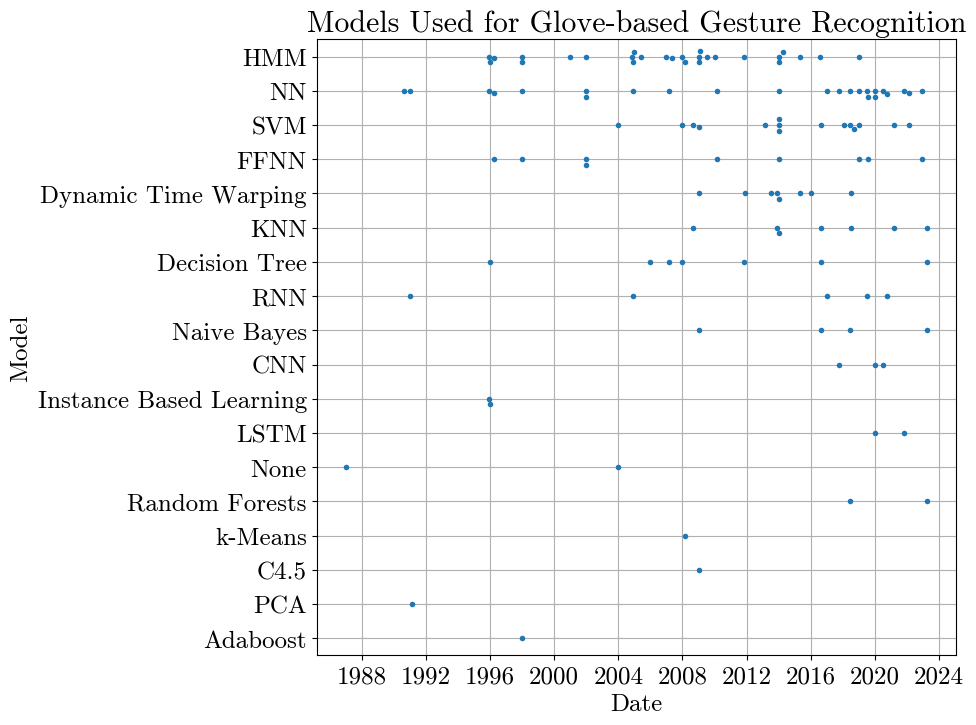

In [73]:
fig, ax = plt.subplots(figsize=(A4_WIDTH_INCHES, 8))
data = dedup_prefix(dedup_prefix(df, 'model'), 'based-on').sort_values('Date')

value_counts = data.value_counts('model')
gt_1_use = value_counts[value_counts > 1].index
data = data[
    (data['model'].isin(gt_1_use)) & 
    (data['based-on'] == 'gloves')
]

order = data.groupby('model').size().sort_values(ascending=False).index
sns.swarmplot(
    data=data,
    x="Date",
    y="model",
#     hue='based-on',
    order=order,
    size=4,
    ax=ax
)
watermark(ax)
ax = prettify_ax(ax)

plt.title('Models Used for Glove-based Gesture Recognition')
# plt.savefig('./src/imgs/graphs/03_models_glove_based.pdf', bbox_inches='tight')

Text(0.5, 1.0, 'Models Used for Non-glove-based Gesture Recognition')

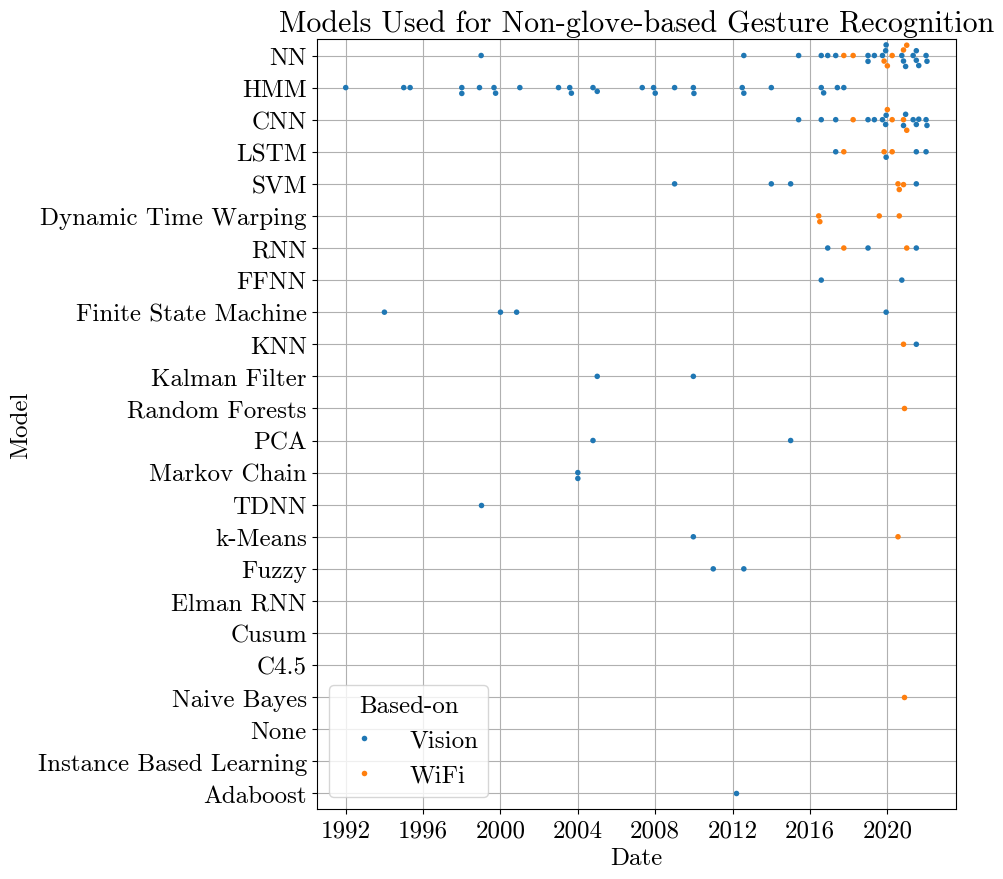

In [74]:
fig, ax = plt.subplots(figsize=(A4_WIDTH_INCHES, 10))
data = dedup_prefix(dedup_prefix(df, 'model'), 'based-on').sort_values('Date')

value_counts = data.value_counts('model')
gt_1_use = value_counts[value_counts > 1].index
data = data[
    (data['model'].isin(gt_1_use)) &
    (data['based-on'] != 'gloves')

]

order = data.groupby('model').size().sort_values(ascending=False).index
sns.swarmplot(
    data=data,
    x="Date",
    y="model",
    hue='based-on',
    order=order,
    size=4,
    ax=ax
)
watermark(ax)
ax = prettify_ax(ax)

plt.title('Models Used for Non-glove-based Gesture Recognition')
# plt.savefig('./src/imgs/graphs/03_models_no_gloves.pdf', bbox_inches='tight')

# Classificaiton models used

## Glove-based

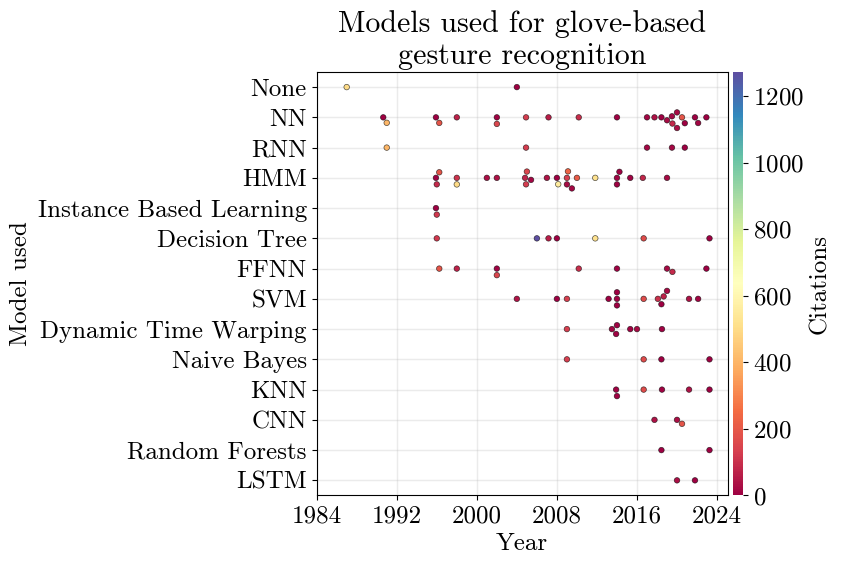

In [141]:
fig, ax = plt.subplots(figsize=(WIDTH, WIDTH))
data = dedup_prefix(dedup_prefix(df, 'model'), 'based-on').sort_values('Date')

data = data[(data.type == 'paper') & (data['based-on'] == 'gloves')]

value_counts = data.value_counts('model')
gt_1_use = value_counts[value_counts > 1].index
data = data[
    (data['model'].isin(gt_1_use))
].sort_values("Date")

data['citations'] = data['citations'].fillna(0)
sns.swarmplot(
    data=data,
    x="Date",
    y="model",
    hue='citations',
    hue_norm=(0, data['citations'].max()),
    palette='Spectral',
    edgecolor='#000a',
    linewidth=0.5,
    legend=False,
    size=4,
    ax=ax
)
prettify_yticks(ax)
add_grid(ax)
add_cbar(
    fig, ax, data['citations'], label='Citations'
)
# handles_labels = (
#     ax.get_legend_handles_labels()[0],
#     [l.title() for l in ax.get_legend_handles_labels()[1]],
# )
# fmt_legend(ax, handles_labels=handles_labels, title='Based-on')

ax.set(
    title='Models used for glove-based\ngesture recognition',
    xticks=ax.get_xticks()[::2],
    xticklabels=ax.get_xticklabels()[::2],
    xlabel='Year',
    ylabel='Model used',
)

plt.savefig('./src/imgs/graphs/03_models_glove_based.pdf', bbox_inches='tight')
plt.show()

## Non-glove-based

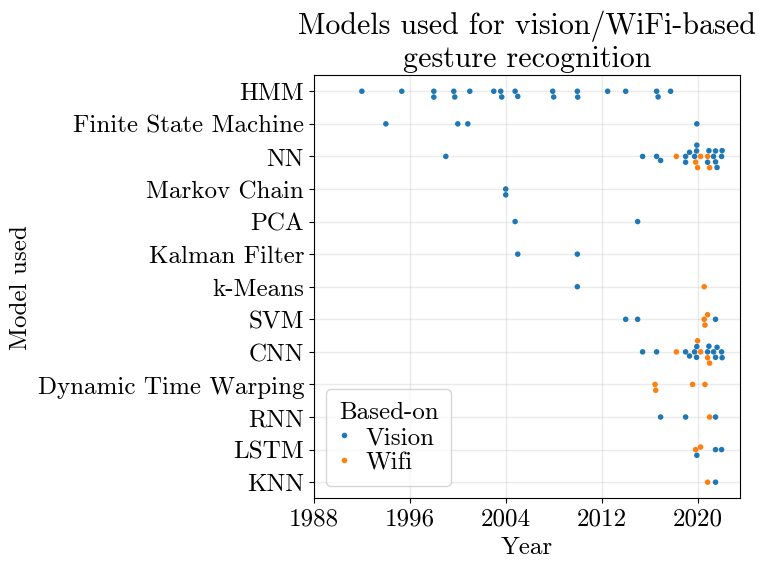

In [143]:
fig, ax = plt.subplots(figsize=(WIDTH, WIDTH))
data = dedup_prefix(dedup_prefix(df, 'model'), 'based-on').sort_values('Date')

data = data[(data.type == 'paper') & (data['based-on'] != 'gloves')]

value_counts = data.value_counts('model')
gt_1_use = value_counts[value_counts > 1].index
data = data[
    (data['model'].isin(gt_1_use))
].sort_values("Date")

sns.swarmplot(
    data=data,
    x="Date",
    y="model",
    hue='based-on',
    size=4,
    ax=ax
)
prettify_yticks(ax)
add_grid(ax)
handles_labels = (
    ax.get_legend_handles_labels()[0],
    [l.title() for l in ax.get_legend_handles_labels()[1]],
)
fmt_legend(ax, handles_labels=handles_labels, title='Based-on')

ax.set(
    title='Models used for vision/WiFi-based\ngesture recognition',
    xticks=ax.get_xticks()[::2],
    xticklabels=ax.get_xticklabels()[::2],
    xlabel='Year',
    ylabel='Model used',
)

plt.savefig('./src/imgs/graphs/03_models_no_gloves.pdf', bbox_inches='tight')
plt.show()

Text(0.5, 1.0, 'HMMs and CNNs for Vision/WiFi-based Gesture Recognition')

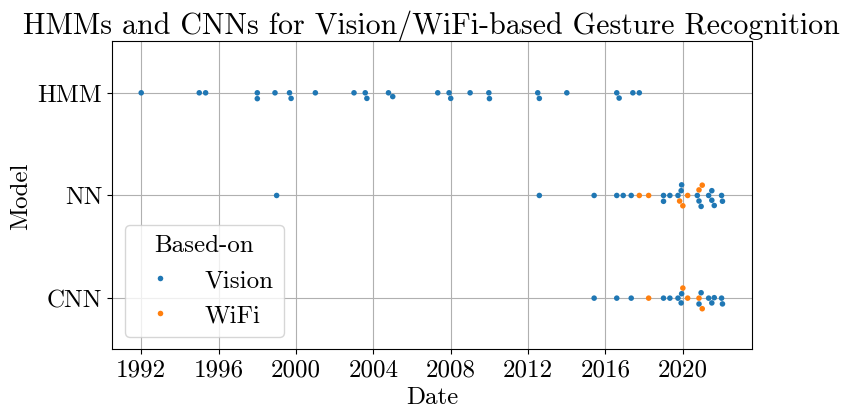

In [76]:
# HMMs vs CNNs/NNs
fig, ax = plt.subplots(figsize=(A4_WIDTH_INCHES, 4))
data = dedup_prefix(dedup_prefix(df, 'model'), 'based-on').sort_values('Date')
data = data[
    (data.model.isin(['nn', 'cnn', 'hmm'])) &
    (data['based-on'].isin(['vision', 'wifi']))
]

# order = data.groupby('model').size().sort_values(ascending=False).index
sns.swarmplot(
    data=data,
    x="Date",
    y="model",
    hue='based-on',
#     order=order,
    size=4,
    ax=ax
)
watermark(ax)
ax = prettify_ax(ax)

plt.title('HMMs and CNNs for Vision/WiFi-based Gesture Recognition')
# plt.savefig('./src/imgs/graphs/03_models_hmm_vs_cnn.pdf', bbox_inches='tight')

<AxesSubplot:xlabel='Date', ylabel='participants'>

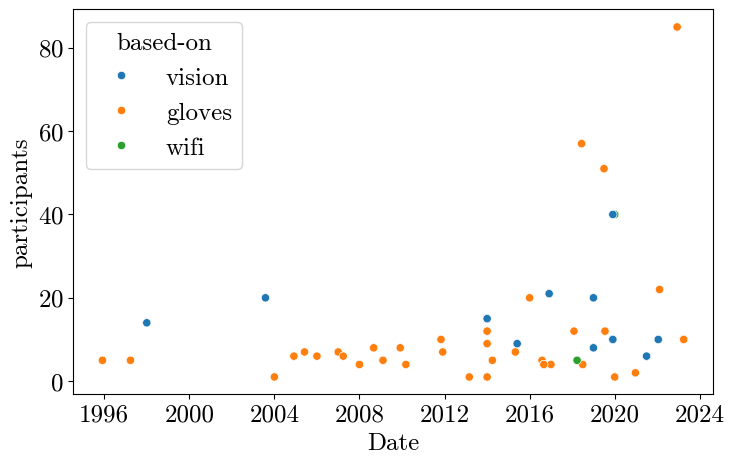

In [77]:
fig, ax = plt.subplots(figsize=(A4_WIDTH_INCHES,5))
data = dedup_prefix(dedup_prefix(dedup_prefix(df, 'model'), 'based-on'), 'participants').sort_values('model')

data['participants'] = (pd.to_numeric(data['participants']))

data = data[
    data['model'].notna()
]

sns.scatterplot(
    data=data,
    y="participants",
    x="Date",
    hue='based-on',
    ax=ax,
)

# watermark(ax)
# ax = prettify_ax(ax)

# ax.set_ylabel('Number of Participants')

# ax.set_xticks(ax.get_xticks())
# ax.set_xticklabels(np.round(np.power(10, ax.get_xticks()), 0))


# plt.title('Model Used vs Number of Participants')
# plt.savefig('./src/imgs/graphs/03_models_vs_nclasses.pdf', bbox_inches='tight')

Text(0.5, 1.0, 'Model Used vs Number of Classes')

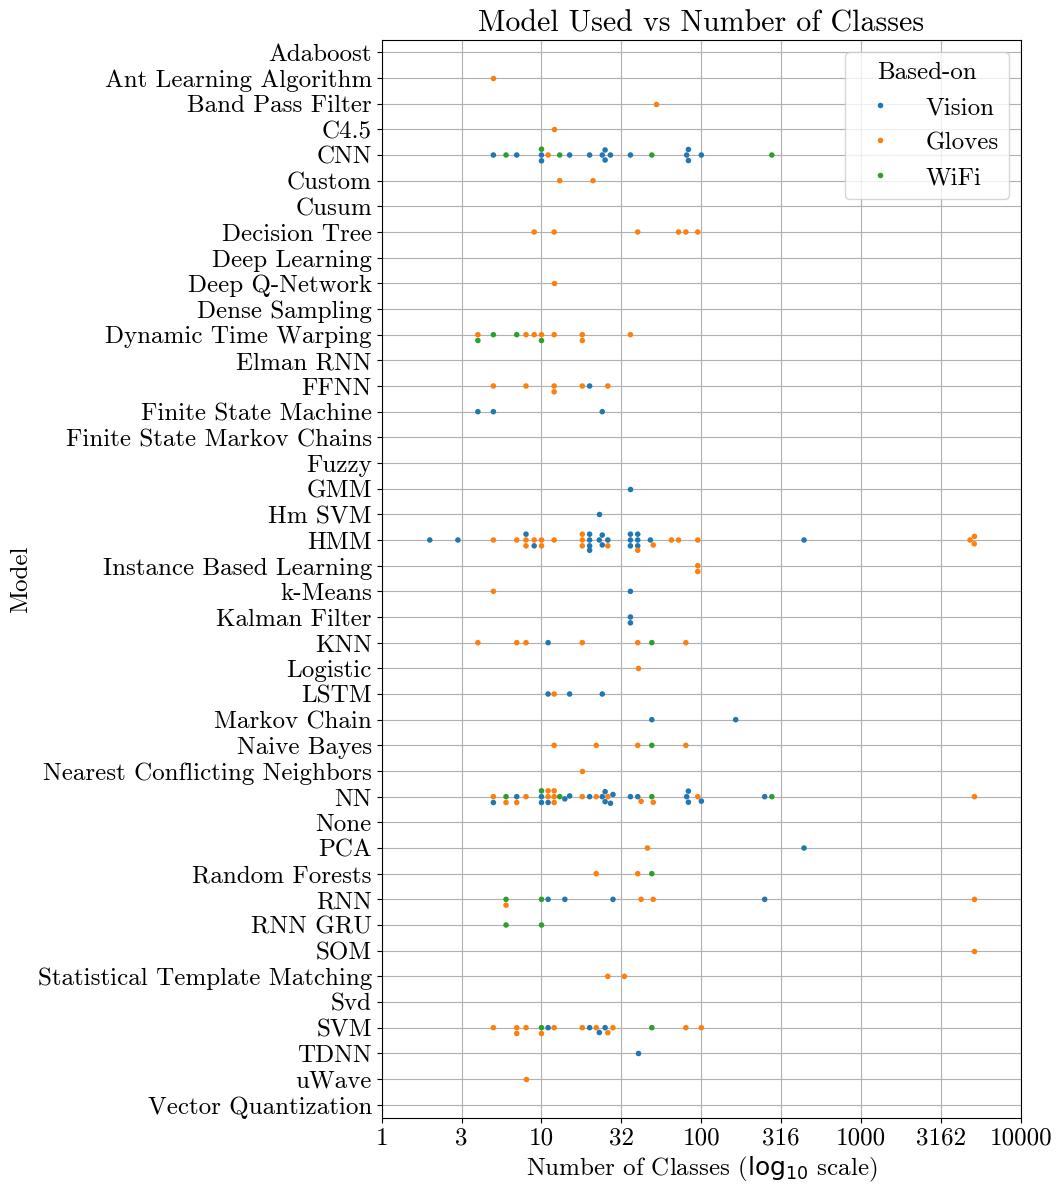

In [78]:
fig, ax = plt.subplots(figsize=(A4_WIDTH_INCHES,14))
data = dedup_prefix(dedup_prefix(dedup_prefix(df, 'model'), 'based-on'), 'classes').sort_values('model')

data['classes'] = np.log10(pd.to_numeric(data['classes']))

data = data[
    data['model'].notna()
]

sns.swarmplot(
    data=data,
    y="model",
    x="classes",
    hue='based-on',
    size=4,
    ax=ax,
)

watermark(ax)
ax = prettify_ax(ax)

ax.set_xlabel('Number of Classes ($\log_{10}$ scale)')

ax.set_xticks(ax.get_xticks())
ax.set_xticklabels((np.round(np.power(10, ax.get_xticks()), 0)).astype(int))


plt.title('Model Used vs Number of Classes')
# plt.savefig('./src/imgs/graphs/03_models_vs_nclasses.pdf', bbox_inches='tight')

# Glove/vision/wifi based systems over time

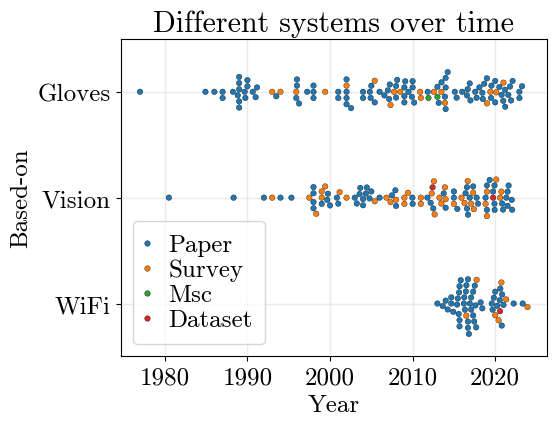

In [96]:
fig, ax = plt.subplots(figsize=(WIDTH, 0.75*WIDTH))
deduped = dedup_prefix(dedup_prefix(df, 'based-on'), 'type')
deduped = deduped[
    deduped.type.isin(['paper', 'survey', 'msc', 'dataset'])
]

sns.swarmplot(
    data=deduped,
    x="Date", 
    y="based-on",
    order=deduped['based-on'].value_counts().index,
    hue='type',
    edgecolor='#000',
    linewidth=0.25,
    size=4, 
    ax=ax,
)
# watermark(ax)
# ax = prettify_ax(ax)

add_grid(ax)
# handles_labels = ax.get_legend_handles_labels()
handles_labels = (
    ax.get_legend_handles_labels()[0],
    [l.title() for l in ax.get_legend_handles_labels()[1]]
)

fmt_legend(ax, handles_labels=handles_labels)
ax.set(
    xlabel='Year',
    ylabel='Based-on',
    title='Different systems over time',
#     xticks=ax.get_xticks()[::2],
#     xticklabels=ax.get_xticklabels()[::2],
)
prettify_yticks(ax)

# plt.title('Trend of Different Systems over Time')
plt.savefig('./src/imgs/graphs/03_based_on_over_time.pdf', bbox_inches='tight')

Text(0.5, 1.0, 'Fidelity of over Time')

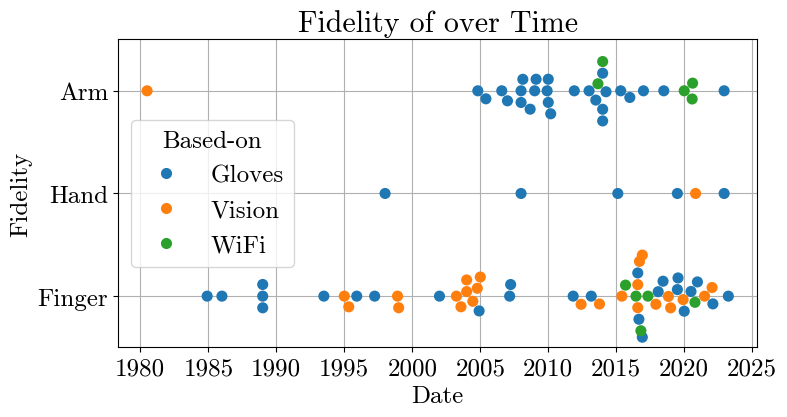

In [137]:
fig, ax = plt.subplots(figsize=(A4_WIDTH_INCHES,4))

data = dedup_prefix(dedup_prefix(df, 'fidelity'), 'based-on')

data = data[
    data['fidelity'].notna()
]
sns.swarmplot(
    data=data, 
    x="Date", 
    y="fidelity",
    hue='based-on',
    size=8,
    ax=ax
)
watermark(ax)    
ax = prettify_ax(ax)


plt.title('Fidelity of over Time')

In [ ]:
# TODO: Save as LaTeX
latex = df.loc[
    (df.type == 'dataset'),
    ['Title', 'Author', 'Date', 'dataset', 'participants', 'observations', 'classes', 'tech', 'hardware']
]

with open('./src/tables/03_datasets.generated.tex', 'w') as f:
    latex.to_latex(
        f,
        caption='caption',
        label='tab:',
        index=False,
        bold_rows=True,
        longtable=True,
        na_rep='-',
        formatters={
            "Date": lambda d: str(d)[:-9],
        }
    )